In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import rcParams as rc
from scipy.optimize import minimize
from scipy.linalg import eigh
import pickle

from qiskit.primitives import Estimator
from qiskit import ClassicalRegister, transpile
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import circuit_drawer, plot_histogram

import sys
sys.path.append("..")
from vqe_algorithm import *

In [3]:
# Cargamos el Hamiltoniano, la repulsión nuclear (ambos para la distancia de equilibrio R = 0.74 Å) y el ansatz de la carpeta data

with open(f"data/hamiltonian0.740.pkl", "rb") as f:
    hamiltonian_eq = pickle.load(f)

with open(f"data/nuclear_repulsion0.740.pkl", "rb") as f:
    nuclear_repulsion_eq = pickle.load(f)

with open(f"data/ansatz.pkl", "rb") as f:
    ansatz = pickle.load(f)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81217061+0.j,  0.17141283+0.j, -0.22343154+0.j,  0.12062523+0.j,
  0.17141283+0.j,  0.16868898+0.j, -0.22343154+0.j,  0.16592785+0.j,
  0.04530262+0.j,  0.04530262+0.j,  0.04530262+0.j,  0.04530262+0.j,
  0.16592785+0.j,  0.17441288+0.j,  0.12062523+0.j])


/home/dperezgcia/miniconda3/envs/qml_avoiding_bp/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


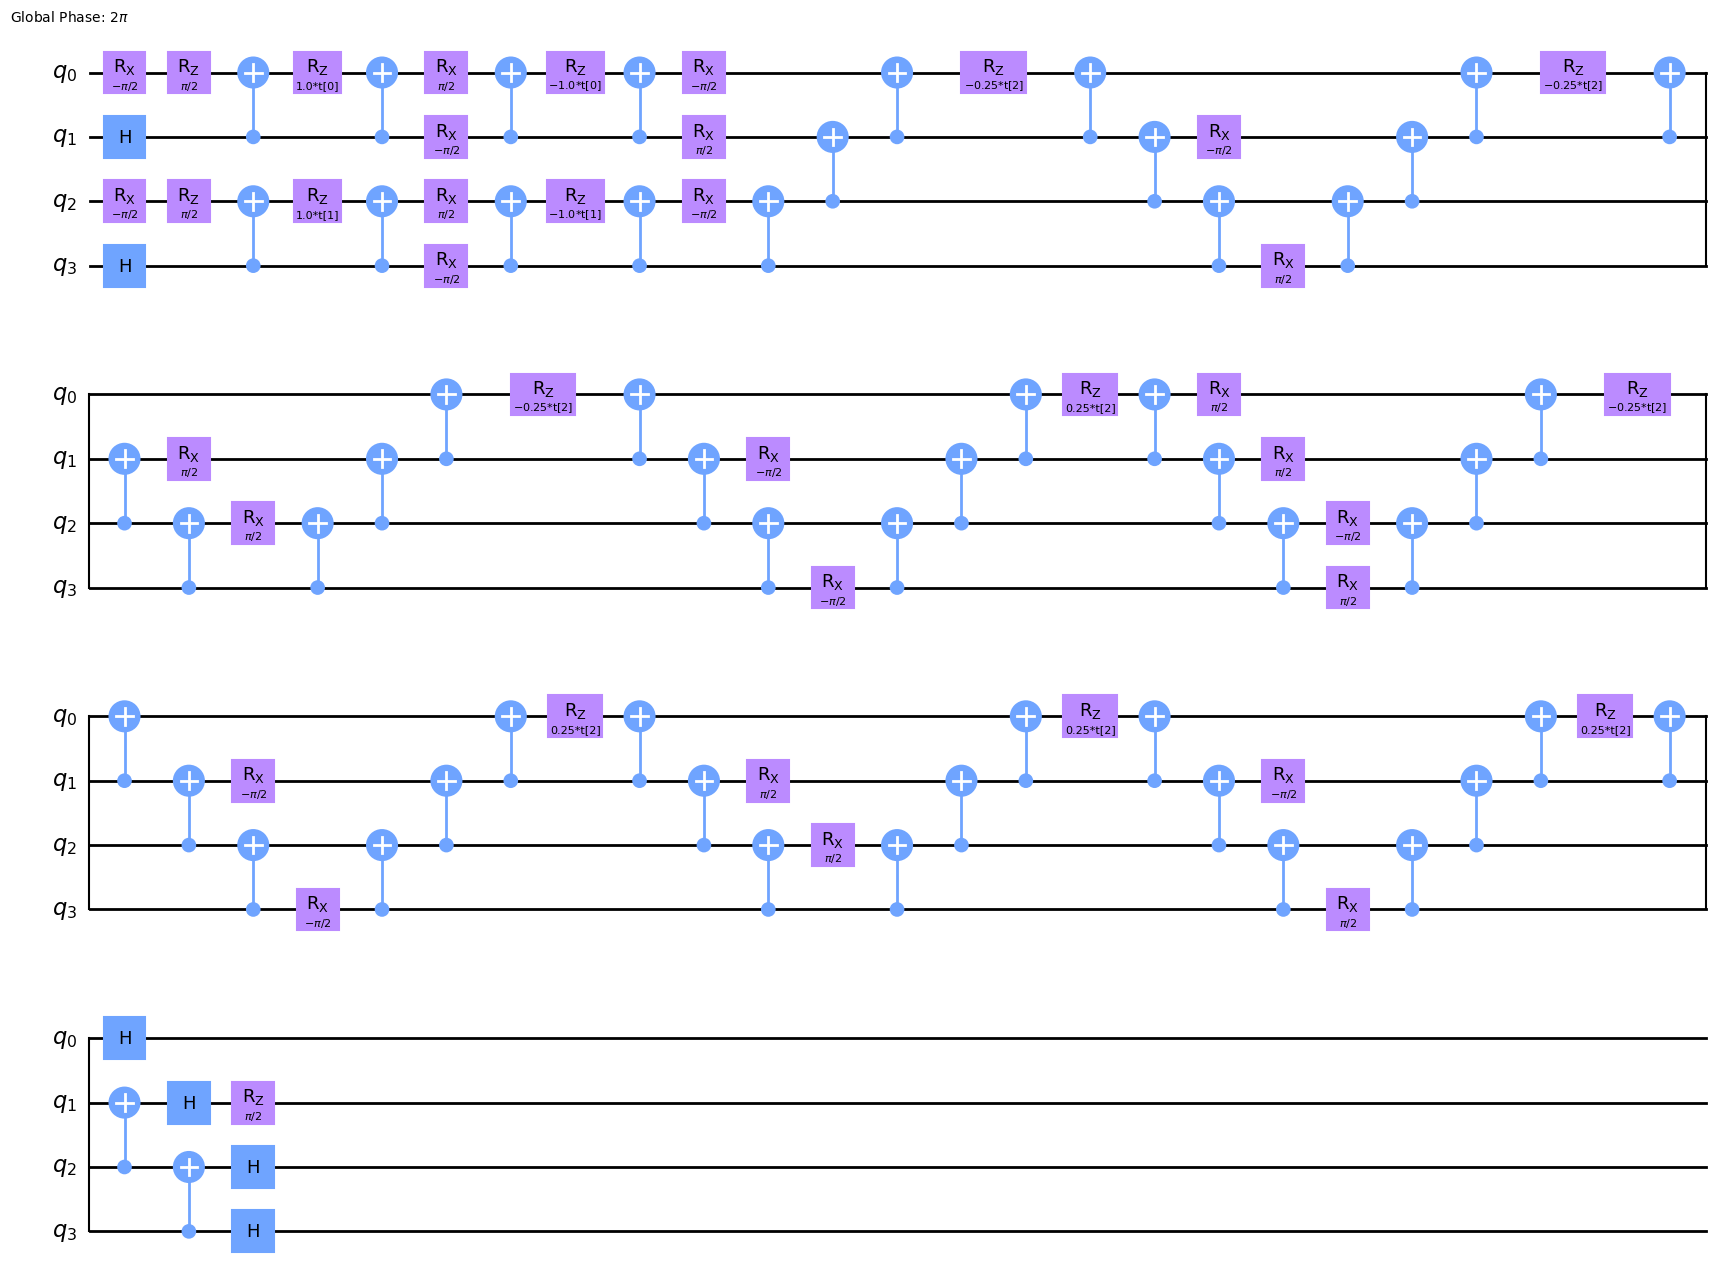

In [ ]:
# Representamos el Hamiltoniano
print(hamiltonian_eq)

# Representamos el ansatz UCCSD en la base seleccionada y guardamos la imagen
basis_gates = ['rx', 'rz', 'cx', 'h']
circuit = transpile(ansatz, basis_gates=basis_gates)

circuit_drawer(
    circuit,
    output='mpl',
    filename='images/ansatz_circuit.png'
    style='clifford'
)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.8523881668840876
       x: [-8.559e-05  2.123e-05 -1.128e-01]
    nfev: 48
   maxcv: 0.0


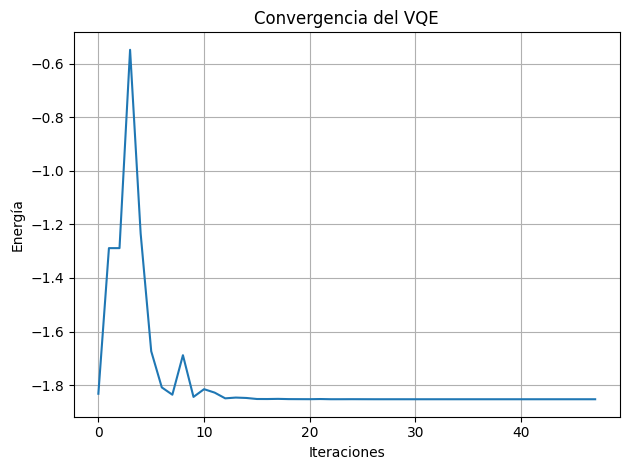

Energía total: -1.1372838278030064


<IPython.core.display.Latex object>

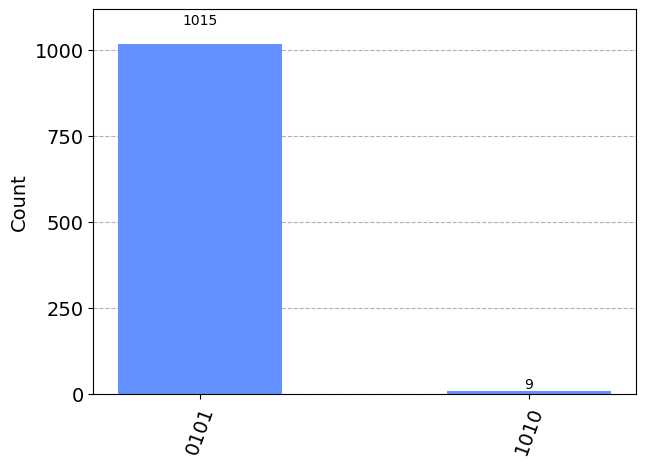

In [5]:
# Aplicamos el VQE y calculamos la energía total
result, cost_history = run_vqe(ansatz, hamiltonian_eq)

# Representamos la evolución de la energía electrónica durante la optimización
print(result)
plot_cost_history(cost_history, "cost_history_equilibrium")

# Calculamos la energía total (energía electrónica + repulsión nuclear)
energy = result["fun"] + nuclear_repulsion_eq
print(f"Energía total: {energy}")

# Obtenemos el estado cuántico
sv = get_statevector(ansatz, result["x"])
display(sv.draw('latex'))

# Simulamos la medición del circuito con parámetors óptimos y representamos el histograma
counts = simulate_measurement(ansatz, result["x"])
fig1 = plot_histogram(counts)
fig1.figure.savefig("images/histogram_counts_equilibrium.png")
display(fig1)

In [ ]:
# Cargamos el resto de Hamiltonianos y repulsiones nucleares de la carpeta data

hamiltonians = {}
nuclear_repulsions = {}

distances = np.linspace(0.25, 2.5, 20)

for dist in distances:
    key = round(dist, 3)  # Usamos una clave con 3 decimales

    with open(f"data/hamiltonian{dist:.3f}.pkl", "rb") as f:
        hamiltonians[key] = pickle.load(f)

    with open(f"data/nuclear_repulsion{dist:.3f}.pkl", "rb") as f:
        nuclear_repulsions[key] = pickle.load(f)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.1477251174895384
       x: [ 8.723e-03 -8.834e-03 -6.904e-01]
    nfev: 867
   maxcv: 0.0


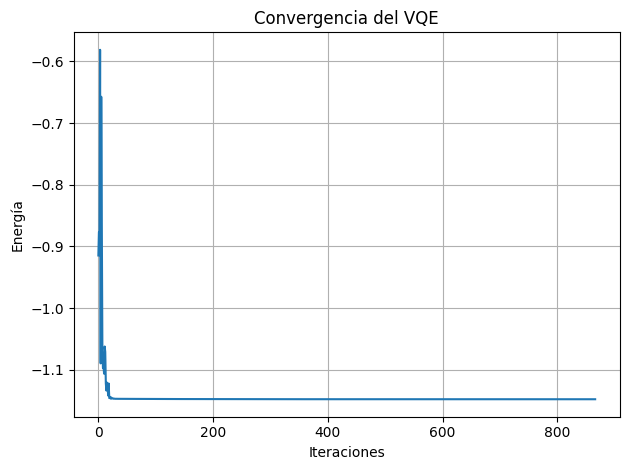

Energía total: -0.9360542331215385


<IPython.core.display.Latex object>

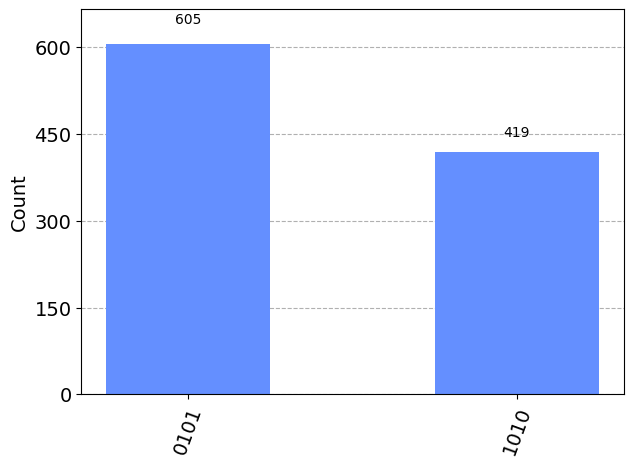

In [9]:
# Repetimos el procedimiento para una distancia internuclear de R = 2.5 Å

result, cost_history = run_vqe(ansatz, hamiltonians[2.5])

print(result)
plot_cost_history(cost_history, "cost_history_2_5")

energy = result["fun"] + nuclear_repulsions[2.5]
print(f"Energía total: {energy}")

sv = get_statevector(ansatz, result["x"])
display(sv.draw('latex'))

counts = simulate_measurement(ansatz, result["x"]) 
fig2 = plot_histogram(counts)
fig2.figure.savefig("images/histogram_counts_2_5.png")
display(fig2)

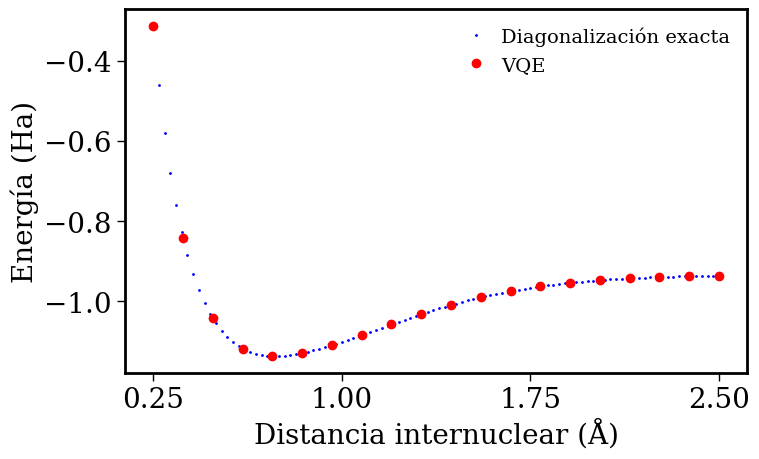

In [23]:
# Estimamos la energía molecular para distancias nucleares entre 0.25 Å y 2.5 Å con el VQE

energies = []

for dist in distances:
    key = round(dist, 3)
    result, cost_history = run_vqe(ansatz, hamiltonians[key])
    e_total = result["fun"] + nuclear_repulsions[key]
    energies.append(e_total)

# Cargamos los Hamiltonianos y repulsiones nucleares para llevar a cabo la diagonalización y comparar los resultados (para 100 distancias)

exact_distances = np.linspace(0.25, 2.5, 100)

hamiltonians_diag = {}
nuclear_repulsions_diag = {}

for dist in exact_distances:
    key = round(dist, 3)

    with open(f"data/hamiltonian{dist:.3f}.pkl", "rb") as f:
        hamiltonians_diag[key] = pickle.load(f)

    with open(f"data/nuclear_repulsion{dist:.3f}.pkl", "rb") as f:
        nuclear_repulsions_diag[key] = pickle.load(f)

# Llevamos a cabo la diagonalización directa del Hamiltoniano

exact_energies = []

for dist in exact_distances:
    key = round(dist, 3)
    matrix = hamiltonians_diag[key].to_matrix() # Convertimos a matriz
    eigenvalues, _ = eigh(matrix) # Autovalores de la matriz
    e_ground = np.min(eigenvalues) # Autovalor más pequeño
    e_total = e_ground + nuclear_repulsions_diag[key]
    exact_energies.append(e_total)


# Comparamos ambos resultados en una gráfica

plt.figure(figsize=(8, 5))
plt.plot(exact_distances, exact_energies,
         color='blue', marker='.', markersize=2, linestyle='None', label='Diagonalización exacta')
plt.plot(distances, energies,
         color='red', marker='o', linestyle='None', label='VQE')
plt.xlabel("Distancia internuclear (Å)")
plt.ylabel("Energía (Ha)")
plt.xticks(np.linspace(0.25, 2.5, 4))
plt.grid(False)
plt.tight_layout()

plt.legend(fontsize=14, frameon=False)
leg = plt.gca().get_legend()
if leg:
    for text in leg.get_texts():
        text.set_fontweight('normal')

plt.tight_layout()
plt.savefig("images/energia_vs_distancia.png", dpi=300)
plt.show()



